In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

In [2]:
# config
CSV_PATH = "bitcoin_prices.csv"
WINDOW_SIZE = 30

# load data and keep Date + High
df = pd.read_csv(CSV_PATH, sep=";")

# convert timeOpen to a date time object
df["Date"] = pd.to_datetime(df["timeOpen"]).dt.date

# keep only Date and daily high price
df = df[["Date", "high"]].rename(columns={"high": "High"})

# convert to chronological order
df = df.sort_values("Date").reset_index(drop=True)

print("First 5 rows after cleaning:")
display(df.head())



First 5 rows after cleaning:


,Date,High
0,2019-01-01,3850.913765
1,2019-01-02,3947.981273
2,2019-01-03,3935.685131
3,2019-01-04,3865.934532
4,2019-01-05,3904.903096


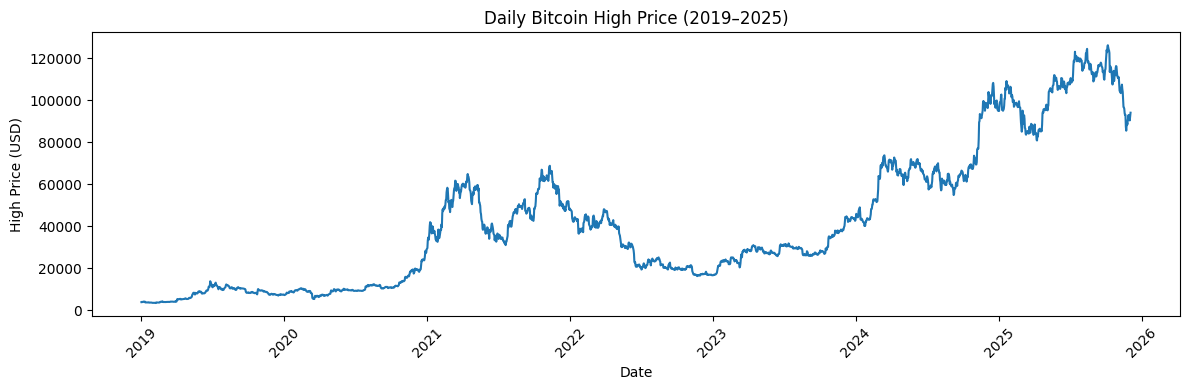

In [3]:
# visualize the series
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["High"])
plt.title("Daily Bitcoin High Price (2019–2025)")
plt.xlabel("Date")
plt.ylabel("High Price (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# train/test split separated by date
# train set: 2019 to 2022
# test set = 2023 to 2025

split_date = pd.to_datetime("2023-01-01").date()

train_df = df[df["Date"] < split_date].copy() # 2019–2022
test_df  = df[df["Date"] >= split_date].copy() # 2023–2025

print(f"Train range: {train_df['Date'].min()} → {train_df['Date'].max()}, days = {len(train_df)}")
print(f"Test  range: {test_df['Date'].min()} → {test_df['Date'].max()}, days = {len(test_df)}")

# scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[["High"]])
test_scaled  = scaler.transform(test_df[["High"]])

# create sliding windows (looks back 30 days to make next day prediction)
def create_sliding_windows(series: np.ndarray, window_size: int = 30):
    """
    series: shape (N, 1) or (N,)
    returns:
        X: (num_samples, window_size, 1)
        y: (num_samples, 1)
    """
    if series.ndim == 1:
        series = series.reshape(-1, 1)

    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size]) # past 30 days
        y.append(series[i + window_size]) # next day

    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = create_sliding_windows(train_scaled, WINDOW_SIZE)
X_test, y_test   = create_sliding_windows(test_scaled, WINDOW_SIZE)

print("\nShapes:")
print("X_train:", X_train.shape)  
print("y_train:", y_train.shape) 
print("X_test: ", X_test.shape)   
print("y_test: ", y_test.shape)



Train range: 2019-01-01 → 2022-12-31, days = 1461
Test  range: 2023-01-01 → 2025-12-03, days = 1068

Shapes:
X_train: (1431, 30, 1)
y_train: (1431, 1)
X_test:  (1038, 30, 1)
y_test:  (1038, 1)


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0245 - mae: 0.0947 - val_loss: 0.0451 - val_mae: 0.1595
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - mae: 0.0436 - val_loss: 0.0236 - val_mae: 0.1050
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - mae: 0.0405 - val_loss: 0.0181 - val_mae: 0.0927
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - mae: 0.0385 - val_loss: 0.0237 - val_mae: 0.1097
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032 - mae: 0.0362 - val_loss: 0.0133 - val_mae: 0.0800
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032 - mae: 0.0357 - val_loss: 0.0075 - val_mae: 0.0616
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034 - mae: 0.0379 - val_loss: 0.0045 - val_mae: 0.0521
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0032 - mae: 0.0356 - val_loss: 0.0081 - val_mae: 0.0632
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.002

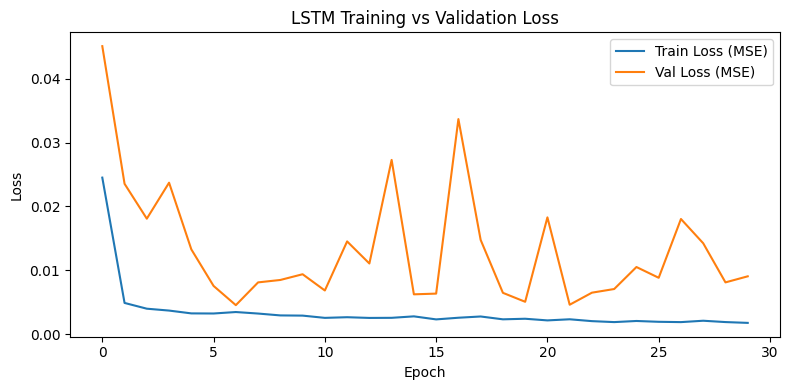

In [6]:
# build lstm keras model
model = keras.Sequential([
    layers.Input(shape=(WINDOW_SIZE, 1)),
    
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    
    layers.LSTM(32),
    layers.Dropout(0.2),
    
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

# train the model
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# plot training and loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


,Date,Actual_High,Predicted_High
0,2023-01-31,23225.021404,23589.722656
1,2023-02-01,23764.539294,23595.806641
2,2023-02-02,24167.210232,23620.001953
3,2023-02-03,23678.102576,23699.601562
4,2023-02-04,23556.948805,23754.837891


Test RMSE (in original price units): 6,216.99


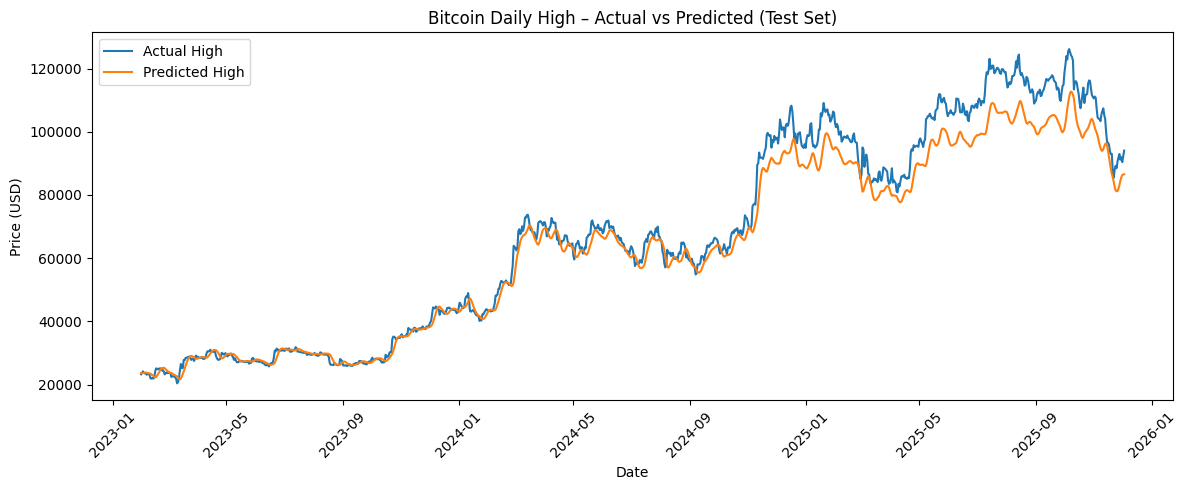

Final Train Loss (MSE): 0.001747
Final Val   Loss (MSE): 0.009047


In [7]:
# predict on test test
y_pred_test = model.predict(X_test)

# inverse-transform to original price space
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred_test)

# align dates so that each y_test corresponds to the day after the 30 day window
test_dates = test_df["Date"].iloc[WINDOW_SIZE:].reset_index(drop=True)

results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual_High": y_test_unscaled.flatten(),
    "Predicted_High": y_pred_unscaled.flatten()
})

display(results_df.head())

# compute rmse
rmse = np.sqrt(mean_squared_error(
    results_df["Actual_High"], 
    results_df["Predicted_High"]
))

print(f"Test RMSE (in original price units): {rmse:,.2f}")

# plot of actual vs predicted on test period
plt.figure(figsize=(12, 5))
plt.plot(results_df["Date"], results_df["Actual_High"], label="Actual High")
plt.plot(results_df["Date"], results_df["Predicted_High"], label="Predicted High")
plt.title("Bitcoin Daily High – Actual vs Predicted (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# train vs validation loss
train_loss_final = history.history["loss"][-1]
val_loss_final = history.history["val_loss"][-1]

print(f"Final Train Loss (MSE): {train_loss_final:.6f}")
print(f"Final Val   Loss (MSE): {val_loss_final:.6f}")